In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

# Construct smooth slip function

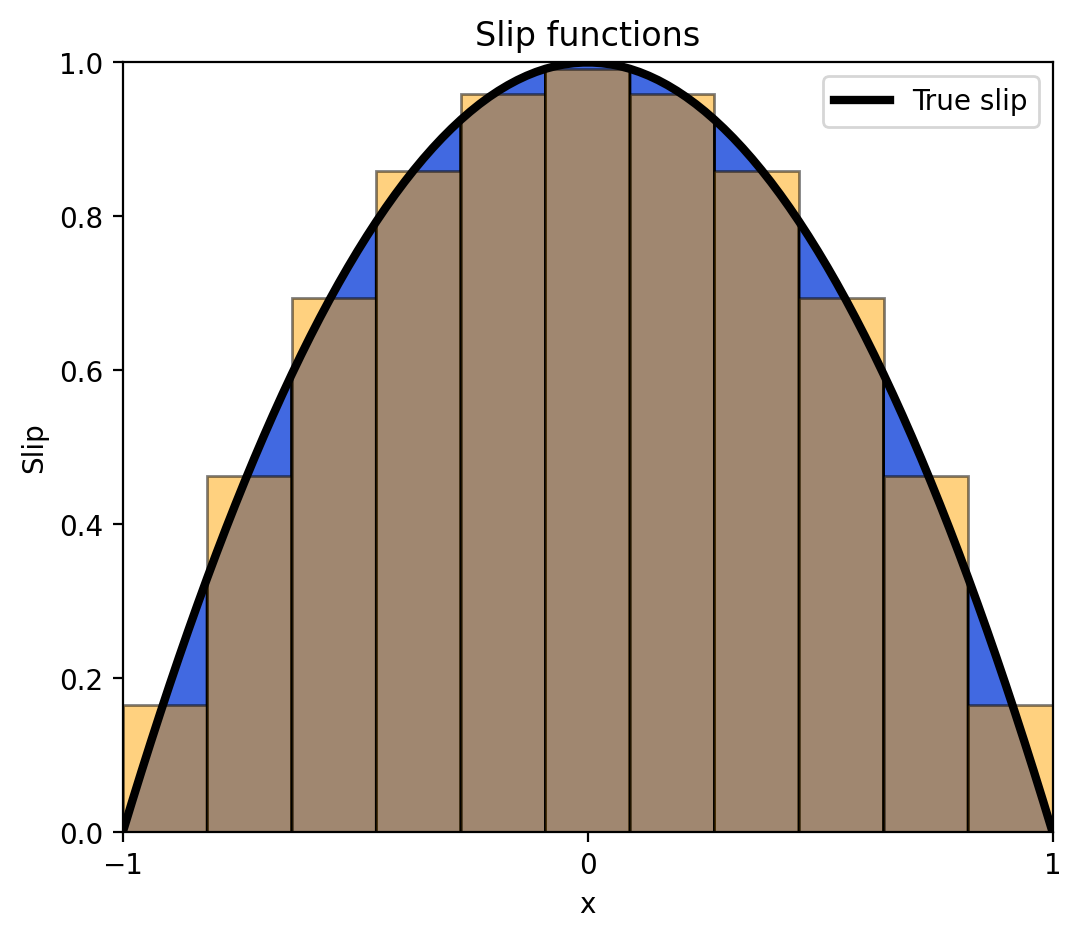

In [3]:
n_pts = 12
n_els = n_pts - 1
a = 1  # fault half-length

x_vals = np.linspace(-a, a, n_pts)

# Define a smooth slip function for a set of parameters (2 exponentials)
"""parameters = np.array([0.8, -0.3, 0.15, 0.2, 0.2, 0.25])
func_slip = lambda x, par: par[0] * np.exp(
    -((x - par[1]) ** 2) / 2 / (par[2] ** 2)
) + par[3] * np.exp(-((x - par[4]) ** 2) / 2 / (par[5] ** 2))
# Slip gradient
func_slip_grad = lambda x, par: -par[0] * (x - par[1]) / (par[2] ** 2) * np.exp(
    -((x - par[1]) ** 2) / 2 / (par[2] ** 2)
) - par[3] * (x - par[4]) / (par[5] ** 2) * np.exp(
    -((x - par[4]) ** 2) / 2 / (par[5] ** 2)
)"""
func_slip = lambda x, par: par[0] * (x**2) + par[1] * x + par[2]
func_slip_grad = lambda x, par: 2 * par[0] * x + par[1]
parameters = np.array([-1, 0, 1])
slip_values = func_slip(x_vals, parameters)

# Define a piecewise constant apprximation to quadratic
x1 = np.zeros(n_els)
x2 = np.zeros(n_els)
constant_slip = np.zeros(n_els)
# quadratic_coefs = np.zeros((n_els, 3))

for i in range(n_els):
    x1[i] = x_vals[i]
    x2[i] = x_vals[i + 1]
    constant_slip[i] = 0.5 * (slip_values[i] + slip_values[i + 1])
    x = np.array([x1[i], 0.5 * (x1[i] + x2[i]), x2[i]])
    # quadratic_coefs[i, :] = bemcs.phicoef(x, func_slip(x), 0.5 * (x2[i] - x1[i]))

plt.figure(figsize=(6, 5))
# Quadratic elements
for i in range(n_els):
    x1[i] = x_vals[i]
    x2[i] = x_vals[i + 1]
    x = np.array([x1[i], 0.5 * (x1[i] + x2[i]), x2[i]])

    plt.fill(
        np.hstack([x, np.flip(x)]),
        np.hstack([func_slip(x, parameters), 0, 0, 0]),
        "royalblue",
        alpha=1,
        edgecolor="k",
    )
    plt.fill(
        [x1[i], x2[i], x2[i], x1[i]],
        [constant_slip[i], constant_slip[i], 0, 0],
        "orange",
        alpha=0.5,
        edgecolor="k",
    )
x = np.linspace(-a, a, 100)
plt.plot(x, func_slip(x, parameters), "k-", linewidth=3, label="True slip")
plt.xlim([-a, a])
plt.xticks([-a, 0, a])
plt.ylim([0, 1])
plt.xlabel("x")
plt.legend()
plt.ylabel("Slip")
plt.title("Slip functions")
plt.show()

# Construct fault geometry

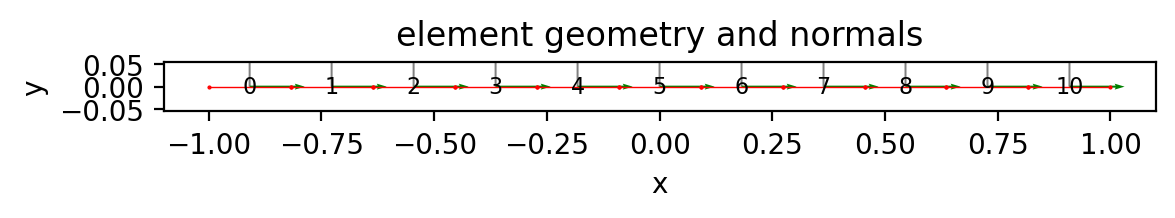

In [4]:
els = bemcs.initialize_els()
els.x1 = x1
els.y1 = np.zeros_like(x1)
els.x2 = x2
els.y2 = np.zeros_like(x1)
bemcs.standardize_els_geometry(els)
bemcs.plot_els_geometry(els)

# Compute displacement and stress kernels (constant slip elements)

In [5]:
mu = 1
nu = 0.25

npts = 900
x_obs = 1.5 * np.linspace(-a, a, npts).reshape(-1, 1)
y_obs = np.zeros_like(x_obs) + 0e-12

# Compute shear and tensile stress kernels (constant slip kernels)
kernels_s = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
_, _, sxx_constant, syy_constant, sxy_constant = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, constant_slip, constant_slip * 0
)

# Compute quadratic coefs that allow for continuous slip

In [6]:
# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0:2] = 0.0
bc_vec[-2:] = 0.0
bc_vec[2::stride] = constant_slip
bc_vec[3::stride] = 0

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

# Compute displacement and stress kernels (quadratic elements)

In [7]:
# Compute shear and tensile stress kernels (quadratic kernels)
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
_, _, sxx_quad, syy_quad, sxy_quad = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

# Plot slip and shear stress comparison

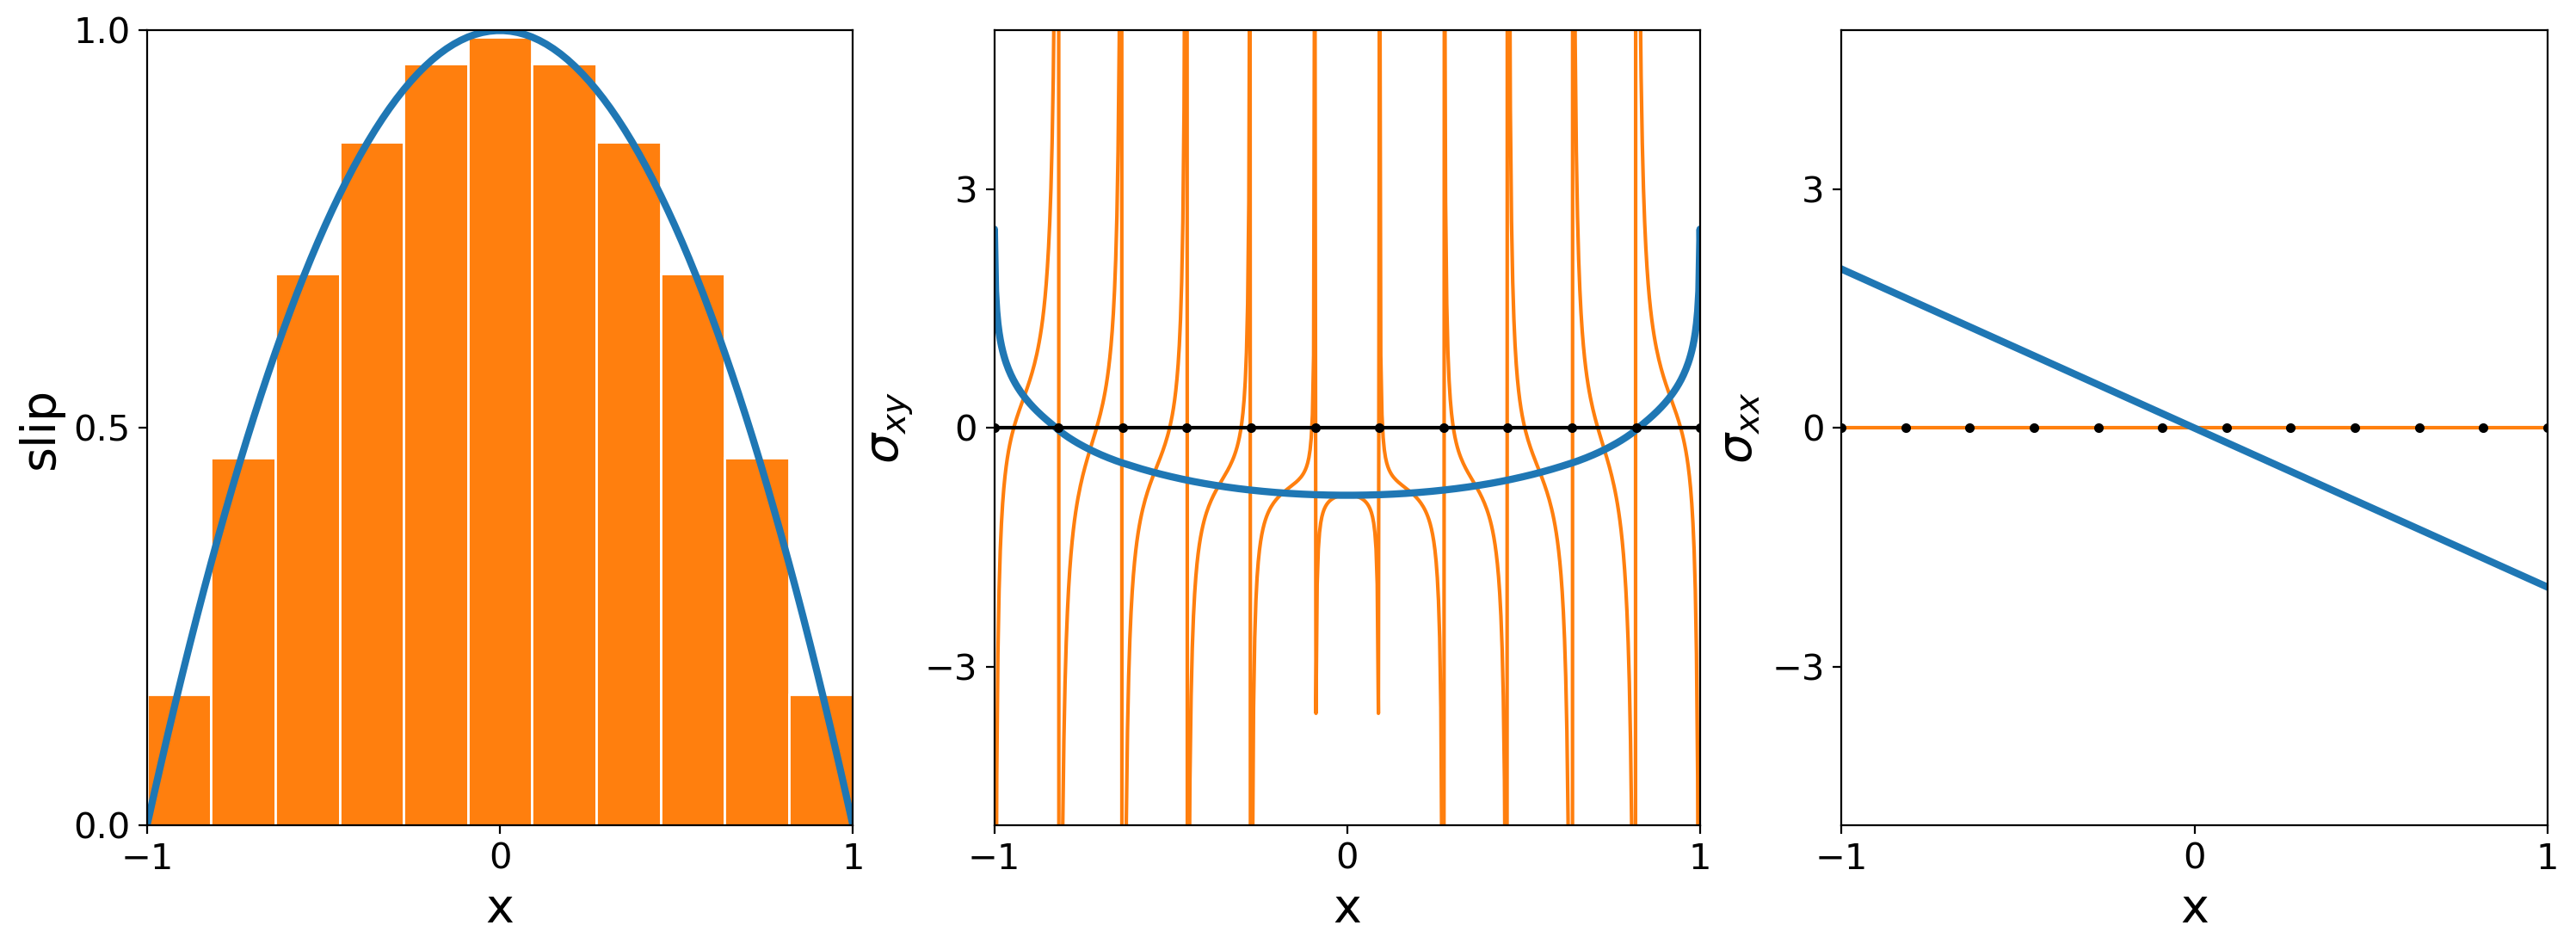

In [8]:
nice_orange = "#ff7f0e"
nice_blue = "#1f77b4"

x = np.linspace(-a, a, 100)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
for i in range(n_els):
    plt.fill(
        [x1[i], x2[i], x2[i], x1[i]],
        [constant_slip[i], constant_slip[i], 0, 0],
        color=nice_orange,
        edgecolor="w",
    )
plt.plot(x, func_slip(x, parameters), "-", linewidth=3, color=nice_blue)
plt.xlim([-a, a])
plt.xticks([-a, 0, a])
plt.ylim([0, 1])
plt.xlabel("x", fontsize=20)
plt.ylabel("slip", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks([0, 0.5, 1], fontsize=15)

plt.subplot(1, 3, 2)
plt.plot(x_obs, sxy_constant, label="constant", color=nice_orange)
plt.plot(x_obs, sxy_quad, label="quadratic", linewidth=3, color=nice_blue)
plt.plot(x_vals, 0 * x_vals, "k.-")
plt.ylim(-5, 5)
plt.xlim(-a, a)
plt.xticks([-a, 0, a], fontsize=15)
plt.xlabel("x", fontsize=20)
plt.ylabel("$\sigma_{xy}$", fontsize=20)
plt.yticks([-3, 0, 3], fontsize=15)

plt.subplot(1, 3, 3)
plt.plot(
    x_obs,
    sxx_constant,
    "-",
    label="constant",
    color=nice_orange,
)
# for i in range(n_els):
#     x = np.linspace(-els.half_lengths[i], els.half_lengths[i], nevals)
#     y = (
#         mu
#         / (1 - nu)
#         * (
#             bemcs.slipgradient_functions(x, els.half_lengths[i])
#             @ coeffs_s[3 * i : 3 * (i + 1)]
#         )
#     )
#     plt.plot(x + els.x_centers[i], y, "-", color=nice_blue, linewidth=3)
plt.plot(x_vals, 0 * x_vals, "k.")
plt.plot(x, func_slip_grad(x, parameters), "-", linewidth=3, color=nice_blue)
plt.xlim([-1, 1])
plt.xticks([-1.0, 0.0, 1.0], fontsize=15)
plt.xlabel("x", fontsize=20)
plt.ylim([-5, 5])
plt.yticks([-3, 0, 3], fontsize=15)
plt.ylabel("$\sigma_{xx}$", fontsize=20)
# plt.savefig("errors_with_constant_slip.pdf")
plt.show()

# Evaluate stresses at element centers

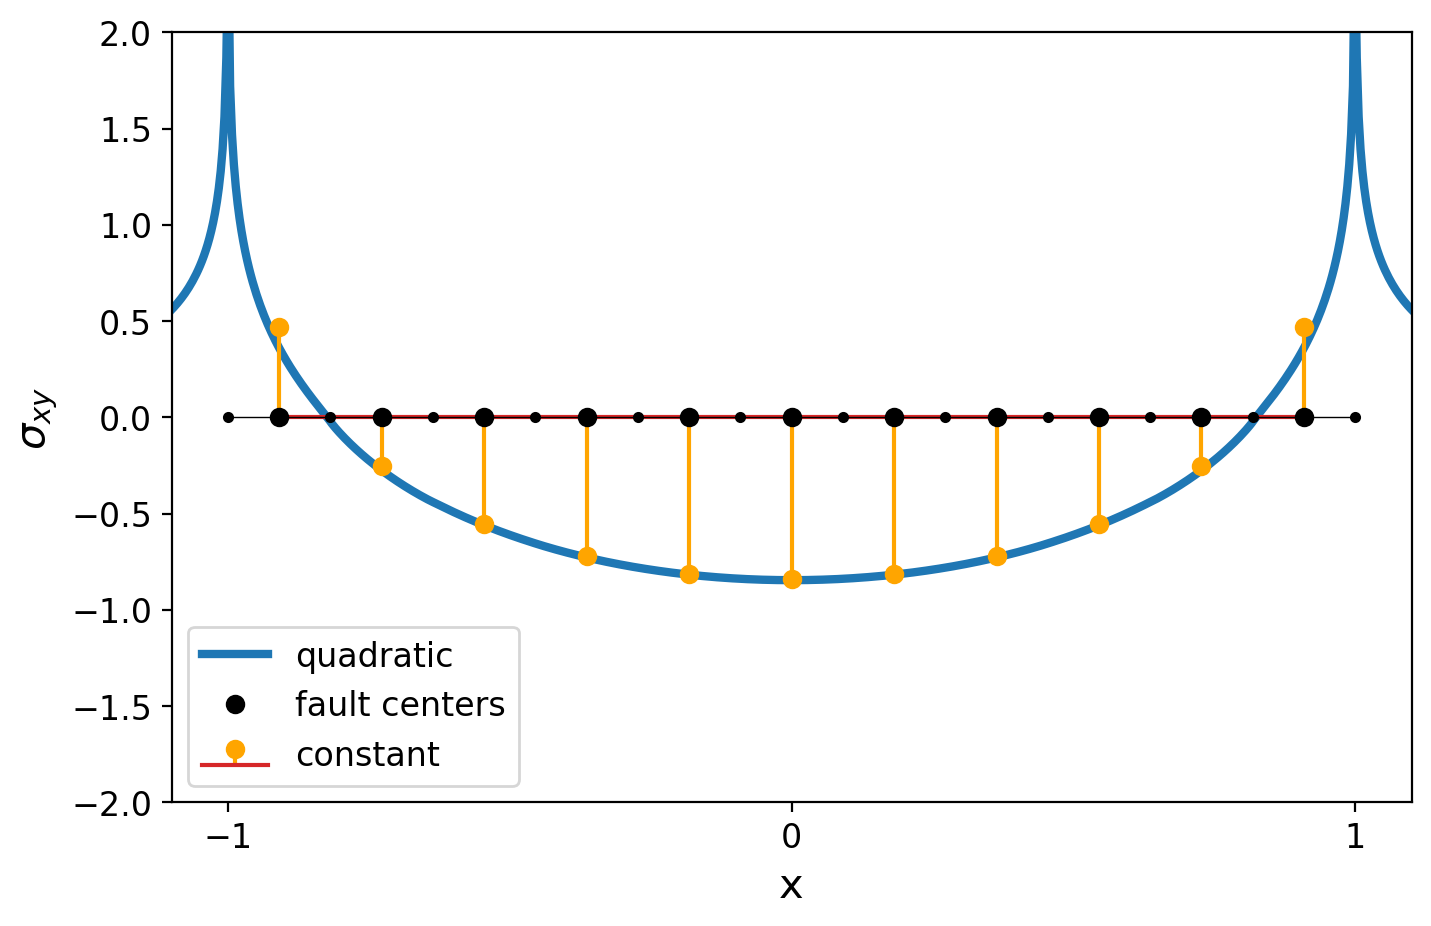

In [9]:
plt.figure(figsize=(8, 5))
plt.plot(x_obs, sxy_quad, label="quadratic", linewidth=3)

x_obs = els.x_centers
y_obs = np.zeros_like(x_obs) + 0e-16

# Compute shear and tensile stress kernels (constant slip kernels)
kernels_s = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel_constant(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
_, _, sxx_constant, syy_constant, sxy_constant = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, constant_slip, constant_slip * 0
)
# Compute shear and tensile stress kernels (quadratic kernels)
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu, nu, flag="normal"
)
_, _, sxx_quad, syy_quad, sxy_quad = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)
# plt.plot(x_obs, sxy_quad, "o", label="quadratic")
plt.stem(x_obs, sxy_constant, "o", label="constant", linefmt="orange")
plt.plot(x_vals, 0 * x_vals, "k.-", linewidth=0.5)
plt.plot(els.x_centers, 0 * els.x_centers, "ko", label="fault centers")
plt.legend(fontsize=12)
plt.xlim(-1.1 * a, 1.1 * a)
plt.ylim(-2, 2)
plt.xticks([-a, 0, a])
plt.xlabel("x", fontsize=15)
plt.ylabel("$\sigma_{xy}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

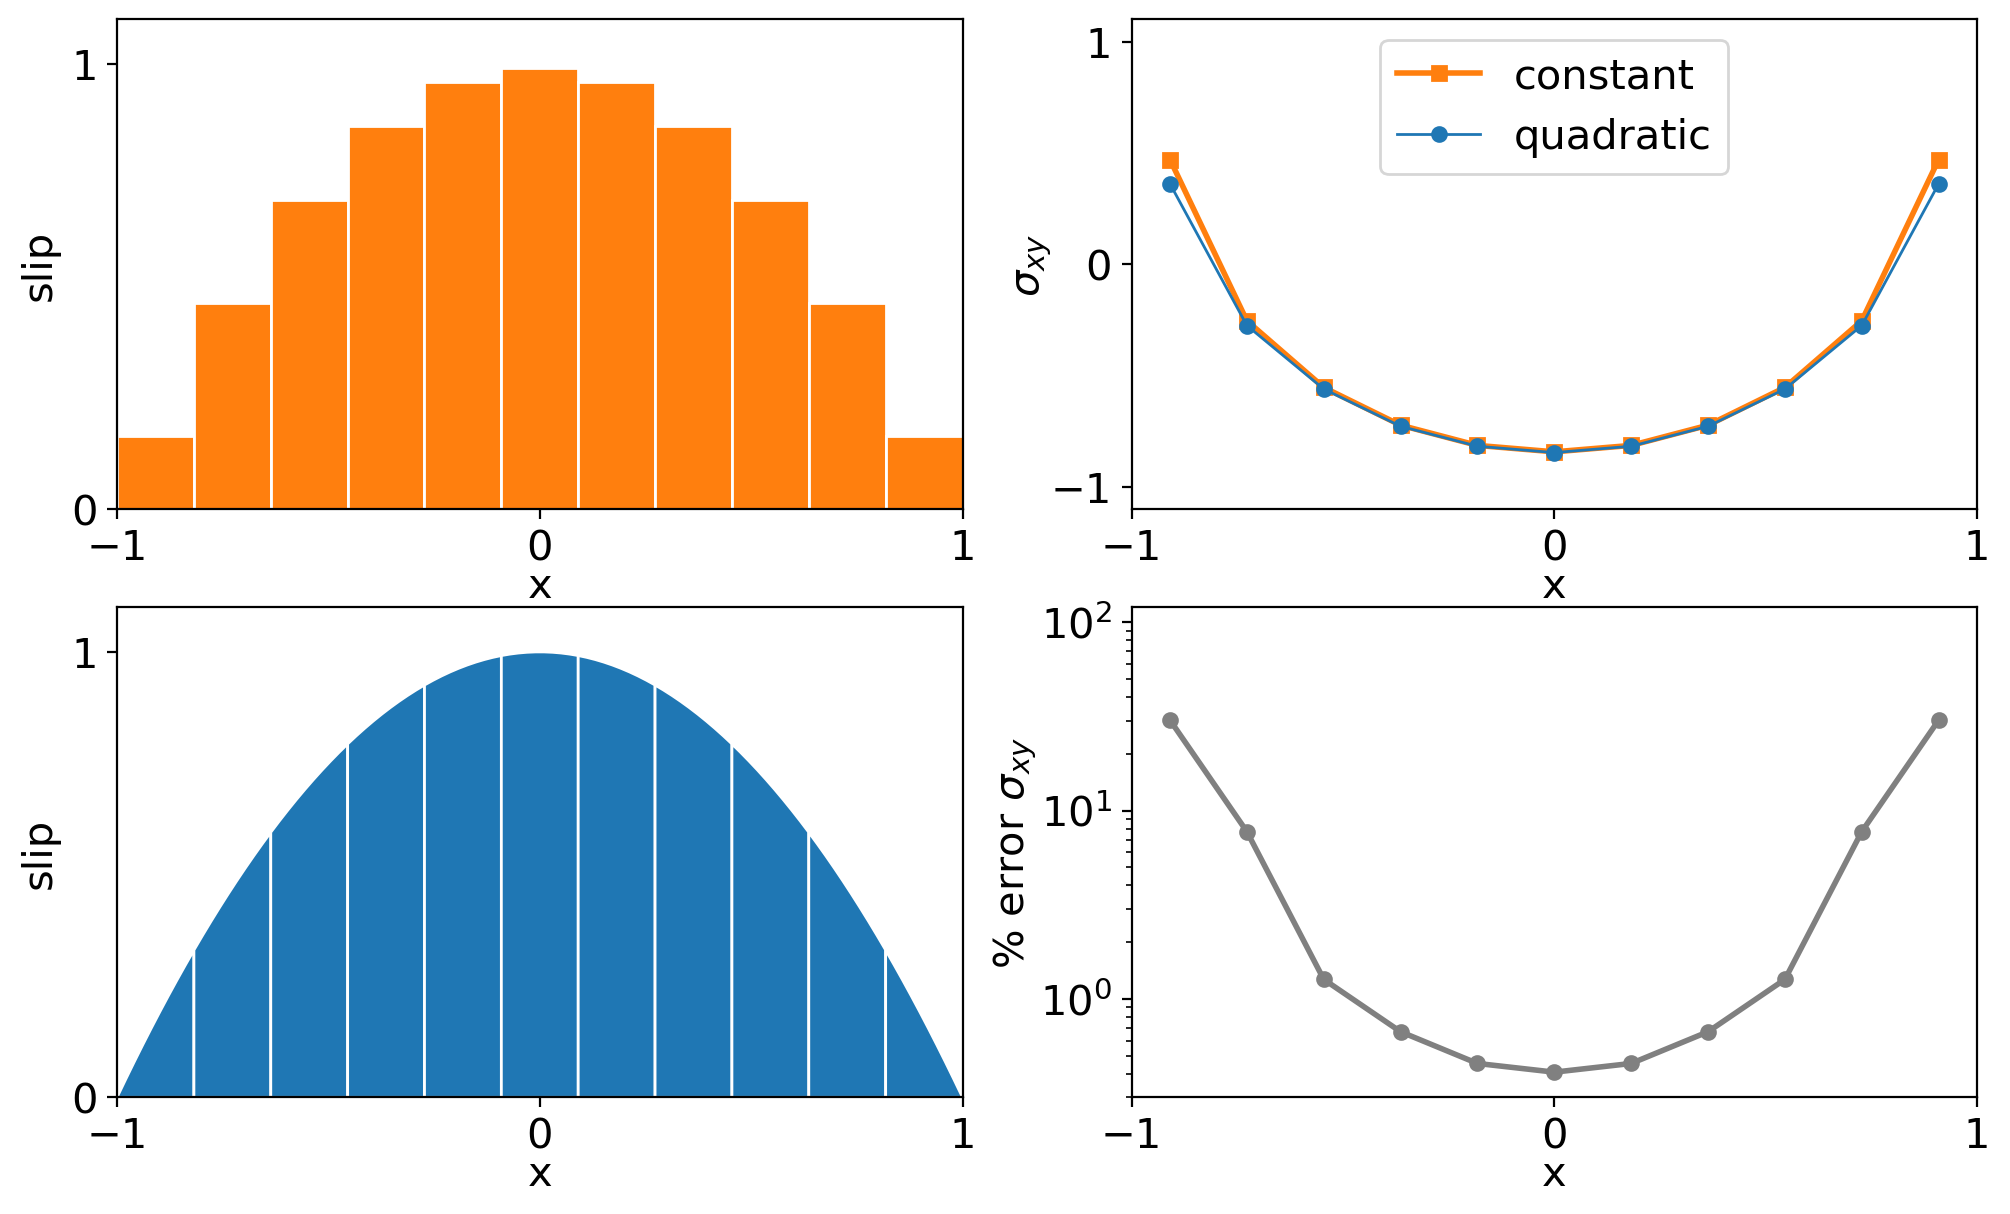

In [28]:
linewidth = 2
markersize = 5
# xy stresses
toplot_xy = np.abs((sxy_quad - sxy_constant) / sxy_quad) * 100
# sxx_quad_analytic = np.zeros_like(sxx_quad)

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
for i in range(n_els):
    plt.fill(
        [x1[i], x2[i], x2[i], x1[i]],
        [constant_slip[i], constant_slip[i], 0, 0],
        color=nice_orange,
        edgecolor="w",
    )
plt.xlim([-1, 1])
plt.ylim([0, 1.1])
plt.xticks([-1, 0, 1], fontsize=15)
plt.yticks([0, 1], fontsize=15)
plt.xlabel("x", labelpad=-1, fontsize=15)
plt.ylabel("slip", fontsize=15)

plt.subplot(2, 2, 3)
for i in range(n_els):
    x = np.linspace(els.x1[i], els.x2[i], 10)

    plt.fill(
        np.hstack([x, np.flip(x)]),
        np.hstack([func_slip(x, parameters), np.zeros_like(x)]),
        color=nice_blue,
        edgecolor="w",
    )
plt.xlim([-1, 1])
plt.ylim([0, 1.1])
plt.xticks([-1, 0, 1], fontsize=15)
plt.yticks([0, 1], fontsize=15)
plt.xlabel("x", labelpad=-1, fontsize=15)
plt.ylabel("slip", fontsize=15)

plt.subplot(2, 2, 2)
plt.plot(
    x_obs,
    sxy_constant,
    "-s",
    linewidth=linewidth,
    label="constant",
    color=nice_orange,
    markersize=markersize,
)
plt.plot(
    x_obs,
    sxy_quad,
    "-o",
    linewidth=linewidth / 2,
    label="quadratic",
    markersize=markersize,
    color=nice_blue,
)
plt.legend(fontsize=15)
plt.ylabel("$\sigma_{xy}$", labelpad=-1, fontsize=15)
plt.xlim([-1, 1])
plt.xticks([-1.0, 0.0, 1.0], fontsize=15)
plt.xlabel("x", labelpad=-1, fontsize=15)
plt.ylim([-1.1, 1.1])
# plt.yscale('log')
plt.yticks([-1, 0, 1], fontsize=15)


plt.subplot(2, 2, 4)
plt.plot(
    x_obs,
    toplot_xy,
    "-o",
    linewidth=linewidth,
    markersize=markersize,
    color="gray",
)
plt.xlabel("x", labelpad=-1, fontsize=15)
plt.ylabel("% error $\sigma_{xy}$", labelpad=0, fontsize=15)
plt.xlim([-1, 1])
plt.xticks([-1.0, 0.0, 1.0], fontsize=15)
plt.yscale("log")
plt.ylim([0.3, 120])
plt.yticks([1, 10, 100], fontsize=15)

plt.savefig("constant_vs_quadratic_on_fault_stresses.pdf")

plt.show()